In [1]:
# =====================================================
# IDENTIFICADOR DE TENIS VERDE OLIVA ("green_SB")
# =====================================================

import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# =====================================================
# 1. CONFIGURACIÓN INICIAL
# =====================================================

# Carpeta base con las imágenes del tenis
base_dir = "green_SB"

# Cargar modelo preentrenado (sin capa final)
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# =====================================================
# 2. FUNCIONES AUXILIARES
# =====================================================

def extraer_features(img_path):
    """Extrae las características de forma/textura usando MobileNetV2"""
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat[0]

def promedio_color(img_path):
    """Calcula el color promedio RGB de la imagen"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean_color = img.mean(axis=(0,1))  # (R, G, B)
    return mean_color

# =====================================================
# 3. EXTRAER Y GUARDAR LAS CARACTERÍSTICAS BASE
# =====================================================

features = []
colors = []
filenames = []

for fname in os.listdir(base_dir):
    if fname.lower().endswith(".jpg"):
        path = os.path.join(base_dir, fname)
        feat = extraer_features(path)
        col = promedio_color(path)
        features.append(feat)
        colors.append(col)
        filenames.append(fname)

features = np.array(features)
colors = np.array(colors)

np.save("greenSB_features.npy", features)
np.save("greenSB_colors.npy", colors)
np.save("greenSB_filenames.npy", filenames)

print(f"✅ Se procesaron {len(filenames)} imágenes del tenis base.")

# =====================================================
# 4. CONSULTAR UNA NUEVA IMAGEN
# =====================================================

def identificar_tenis(imagen_nueva, alpha=0.8):
    """
    Compara la imagen nueva con la base de datos.
    alpha controla el peso de la similitud de forma vs color.
    1.0 = solo forma, 0.0 = solo color
    """
    # Cargar datos base
    features = np.load("greenSB_features.npy")
    colors = np.load("greenSB_colors.npy")
    filenames = np.load("greenSB_filenames.npy", allow_pickle=True)
    
    # Extraer características de la imagen nueva
    feat_new = extraer_features(imagen_nueva)
    color_new = promedio_color(imagen_nueva)
    
    # Similitud de forma
    sims_forma = cosine_similarity([feat_new], features)[0]
    
    # Similitud de color (convertimos a similitud, no distancia)
    dist_color = np.linalg.norm(colors - color_new, axis=1)
    sims_color = 1 / (1 + dist_color)  # mayor valor = más parecido
    
    # Combinación ponderada
    sims_total = alpha * sims_forma + (1 - alpha) * sims_color
    best_idx = np.argmax(sims_total)
    
    mejor_img = os.path.join(base_dir, filenames[best_idx])
    similitud = sims_total[best_idx]
    
    # Mostrar resultado
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image.load_img(imagen_nueva))
    plt.title("🆕 Imagen nueva")
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.imshow(image.load_img(mejor_img))
    plt.title(f"Más similar\n({similitud:.3f})")
    plt.axis('off')
    plt.show()
    
    if similitud > 0.8:
        print("✅ Es muy probable que sea el mismo tenis.")
    elif similitud > 0.6:
        print("⚠️ Podría ser el mismo, pero con diferencias.")
    else:
        print("❌ No parece ser el mismo tenis.")

# =====================================================
# 5. USO DEL PROGRAMA
# =====================================================

# Ejemplo:
# identificar_tenis("foto_nueva.jpg", alpha=0.8)


C:\Users\hp\miniconda3\envs\calzadoIA\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_22084\3757293890.py:21: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Se procesaron 50 imágenes del tenis base.


🔍 Analizando: IMG-20250408-WA0034.jpg


C:\Users\hp\miniconda3\envs\calzadoIA\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127381 (\N{SQUARED NEW}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


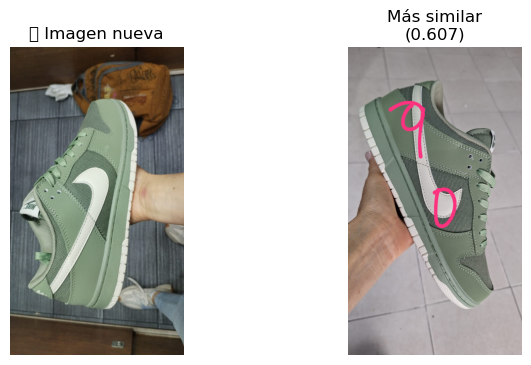

⚠️ Podría ser el mismo, pero con diferencias.


In [17]:
# =====================================================
# 5. USO DEL PROGRAMA (versión con selector de archivo)
# =====================================================
from tkinter import Tk, filedialog

def seleccionar_y_identificar(alpha=0.8):
    """Abre un cuadro de diálogo para seleccionar una imagen y la analiza."""
    root = Tk()
    root.withdraw()  # Oculta la ventana principal de Tkinter
    root.call('wm', 'attributes', '.', '-topmost', True)  # Trae el cuadro al frente

    file_path = filedialog.askopenfilename(
        title="Selecciona una imagen para analizar",
        filetypes=[("Archivos de imagen", "*.jpg *.jpeg *.png")]
    )
    
    if not file_path:
        print("❌ No se seleccionó ninguna imagen.")
        return
    
    print(f"🔍 Analizando: {os.path.basename(file_path)}")
    identificar_tenis(file_path, alpha)

# =====================================================
# 6. EJECUCIÓN
# =====================================================
# Simplemente ejecuta esta línea para abrir el selector:
# Puedes ajustar alpha (0.5 a 1.0) según cuánto peso darle al color.
seleccionar_y_identificar(alpha=0.8)


## Para cinco estilos

In [1]:
# =====================================================
# CLASIFICADOR DE TENIS POR ESTILO (5 carpetas)
# =====================================================

import os
import numpy as np
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog

# =====================================================
# 1. CONFIGURACIÓN
# =====================================================

dataset_dir = "tenis_dataset"  # Carpeta principal que contiene las 5 subcarpetas
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# =====================================================
# 2. FUNCIONES
# =====================================================

def extraer_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat[0]

def promedio_color(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean_color = img.mean(axis=(0,1))
    return mean_color

# =====================================================
# 3. CALCULAR VECTOR PROMEDIO PARA CADA TENIS
# =====================================================

tenis_features = {}
tenis_colors = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    feats, cols = [], []
    for fname in os.listdir(class_path):
        if fname.lower().endswith(".jpg"):
            path = os.path.join(class_path, fname)
            feats.append(extraer_features(path))
            cols.append(promedio_color(path))
    
    feats = np.array(feats)
    cols = np.array(cols)
    tenis_features[class_name] = feats.mean(axis=0)
    tenis_colors[class_name] = cols.mean(axis=0)
    print(f"✅ Procesadas {len(feats)} imágenes para {class_name}")

# Guardar
np.save("tenis_features.npy", tenis_features)
np.save("tenis_colors.npy", tenis_colors)
print("\n✅ Vectores promedio creados para todos los tenis.\n")

# =====================================================
# 4. CLASIFICAR UNA IMAGEN NUEVA
# =====================================================

def clasificar_tenis(imagen_nueva, alpha=0.8):
    tenis_features = np.load("tenis_features.npy", allow_pickle=True).item()
    tenis_colors = np.load("tenis_colors.npy", allow_pickle=True).item()

    feat_new = extraer_features(imagen_nueva)
    color_new = promedio_color(imagen_nueva)

    resultados = []

    for nombre, feat_avg in tenis_features.items():
        color_avg = tenis_colors[nombre]
        
        sim_forma = cosine_similarity([feat_new], [feat_avg])[0][0]
        dist_color = np.linalg.norm(color_avg - color_new)
        sim_color = 1 / (1 + dist_color)
        
        sim_total = alpha * sim_forma + (1 - alpha) * sim_color
        resultados.append((nombre, sim_total))
    
    resultados.sort(key=lambda x: x[1], reverse=True)
    mejor = resultados[0]

    # Mostrar resultado visual
    plt.figure(figsize=(5,5))
    plt.imshow(image.load_img(imagen_nueva))
    plt.title(f"Predicción: {mejor[0]}\nSimilitud: {mejor[1]:.3f}")
    plt.axis('off')
    plt.show()

    print("🔍 Resultados de similitud:")
    for nombre, sim in resultados:
        print(f" - {nombre}: {sim:.3f}")

# =====================================================
# 5. SELECCIONAR IMAGEN DESDE EXPLORADOR
# =====================================================

def seleccionar_y_clasificar(alpha=0.8):
    root = Tk()
    root.withdraw()
    root.call('wm', 'attributes', '.', '-topmost', True)
    file_path = filedialog.askopenfilename(
        title="Selecciona una imagen para clasificar",
        filetypes=[("Archivos de imagen", "*.jpg *.jpeg *.png")]
    )
    if not file_path:
        print("❌ No se seleccionó ninguna imagen.")
        return
    
    print(f"🆕 Analizando: {os.path.basename(file_path)}")
    clasificar_tenis(file_path, alpha)

# =====================================================
# 6. EJECUCIÓN
# =====================================================
# Ejecuta esta línea para abrir el explorador y clasificar una imagen
#seleccionar_y_clasificar(alpha=0.8)


C:\Users\hp\miniconda3\envs\calzadoIA\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
C:\Users\hp\AppData\Local\Temp\ipykernel_21736\3217167116.py:19: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


✅ Procesadas 55 imágenes para AF1
✅ Procesadas 49 imágenes para EQ
✅ Procesadas 50 imágenes para green_SB
✅ Procesadas 50 imágenes para nike_SB
✅ Procesadas 62 imágenes para samba
✅ Procesadas 60 imágenes para TN

✅ Vectores promedio creados para todos los tenis.



🆕 Analizando: IMG-20250506-WA0000.jpg


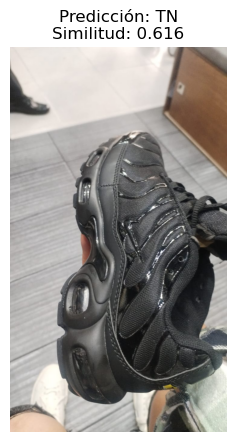

🔍 Resultados de similitud:
 - TN: 0.616
 - AF1: 0.503
 - EQ: 0.498
 - green_SB: 0.492
 - nike_SB: 0.488
 - samba: 0.488


In [3]:
seleccionar_y_clasificar(alpha=0.8)

C:\Users\hp\AppData\Local\Temp\ipykernel_5004\3799842137.py:22: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


👀 Monitoreando carpeta: 2025-10-10
📸 Esperando nuevas imágenes...

🆕 Nueva imagen detectada: IMG-20250329-WA0041.jpg
   → Predicción: AF1  (Similitud: 0.606)



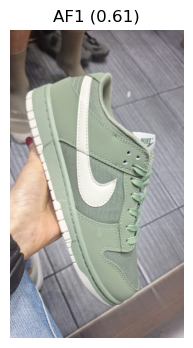

🆕 Nueva imagen detectada: IMG-20250329-WA0045.jpg
   → Predicción: EQ  (Similitud: 0.674)



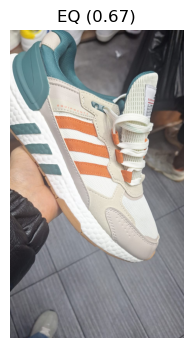

🆕 Nueva imagen detectada: IMG-20250611-WA0038.jpg
   → Predicción: samba  (Similitud: 0.633)



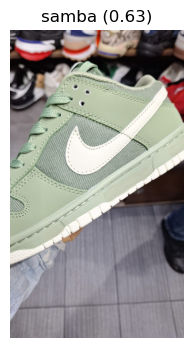

🆕 Nueva imagen detectada: IMG-20250612-WA0001.jpg
   → Predicción: AF1  (Similitud: 0.672)



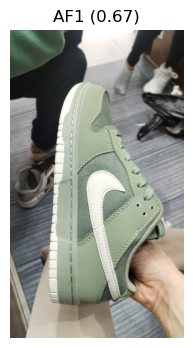

🆕 Nueva imagen detectada: IMG-20250329-WA0041.jpg
   → Predicción: AF1  (Similitud: 0.606)



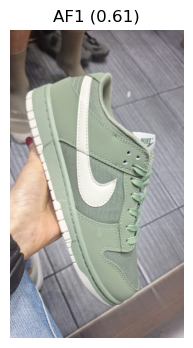

In [10]:
# ==========================================================
# MONITOR AUTOMÁTICO DE CARPETA - CLASIFICADOR DE TENIS
# ==========================================================
import os
import time
import cv2
import numpy as np
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# ==========================================================
# CONFIGURACIÓN
# ==========================================================
carpeta_monitoreada = "2025-10-10"  # 📂 Donde llegan las fotos nuevas
alpha = 0.8                                # Peso entre forma y color

# Cargar modelo y vectores promedio
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
tenis_features = np.load("tenis_features.npy", allow_pickle=True).item()
tenis_colors = np.load("tenis_colors.npy", allow_pickle=True).item()

# ==========================================================
# FUNCIONES
# ==========================================================
def extraer_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat[0]

def promedio_color(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean_color = img.mean(axis=(0,1))
    return mean_color

def clasificar_tenis(imagen_nueva, alpha=0.8):
    feat_new = extraer_features(imagen_nueva)
    color_new = promedio_color(imagen_nueva)
    resultados = []

    for nombre, feat_avg in tenis_features.items():
        color_avg = tenis_colors[nombre]
        sim_forma = cosine_similarity([feat_new], [feat_avg])[0][0]
        dist_color = np.linalg.norm(color_avg - color_new)
        sim_color = 1 / (1 + dist_color)
        sim_total = alpha * sim_forma + (1 - alpha) * sim_color
        resultados.append((nombre, sim_total))
    
    resultados.sort(key=lambda x: x[1], reverse=True)
    mejor = resultados[0]
    
    print(f"🆕 Nueva imagen detectada: {os.path.basename(imagen_nueva)}")
    print(f"   → Predicción: {mejor[0]}  (Similitud: {mejor[1]:.3f})\n")

    # Mostrar imagen con predicción
    plt.figure(figsize=(4,4))
    plt.imshow(image.load_img(imagen_nueva))
    plt.title(f"{mejor[0]} ({mejor[1]:.2f})")
    plt.axis('off')
    plt.show()

# ==========================================================
# MONITOREO DE LA CARPETA
# ==========================================================
class MonitorCarpeta(FileSystemEventHandler):
    def on_created(self, event):
        if not event.is_directory and event.src_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            time.sleep(1)  # Esperar un segundo por si el archivo aún se está copiando
            clasificar_tenis(event.src_path, alpha)

observer = Observer()
observer.schedule(MonitorCarpeta(), carpeta_monitoreada, recursive=False)

print(f"👀 Monitoreando carpeta: {carpeta_monitoreada}")
print("📸 Esperando nuevas imágenes...\n")

observer.start()

try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    observer.stop()
observer.join()


## Esperar que la imagen este completa

C:\Users\hp\AppData\Local\Temp\ipykernel_21736\2877015352.py:25: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')


👀 Monitoreando carpeta: 2025-10-10
Arrastra o guarda aquí las imágenes a clasificar...


📸 Nueva imagen detectada: IMG-20250408-WA0034.jpg
✅ Archivo completamente guardado, iniciando análisis...


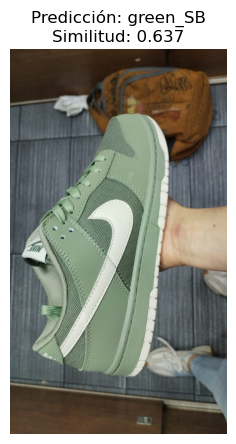


🔍 Resultados de similitud:
 - green_SB: 0.637
 - AF1: 0.583
 - nike_SB: 0.583
 - samba: 0.576
 - EQ: 0.542
 - TN: 0.527

📸 Nueva imagen detectada: 1760129494024.jpeg
✅ Archivo completamente guardado, iniciando análisis...


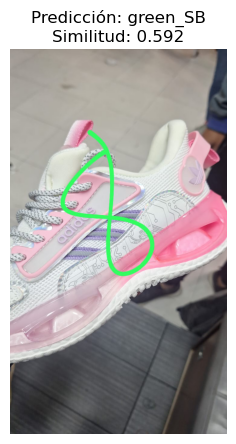


🔍 Resultados de similitud:
 - green_SB: 0.592
 - EQ: 0.564
 - nike_SB: 0.564
 - samba: 0.561
 - AF1: 0.556
 - TN: 0.519

📸 Nueva imagen detectada: 1760129907807.jpeg
✅ Archivo completamente guardado, iniciando análisis...


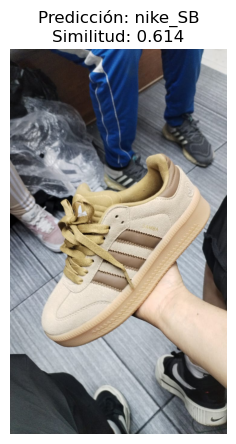


🔍 Resultados de similitud:
 - nike_SB: 0.614
 - samba: 0.614
 - AF1: 0.603
 - EQ: 0.582
 - green_SB: 0.565
 - TN: 0.563

📸 Nueva imagen detectada: 1760130796237.jpeg
✅ Archivo completamente guardado, iniciando análisis...


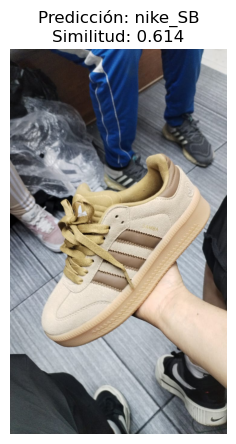


🔍 Resultados de similitud:
 - nike_SB: 0.614
 - samba: 0.614
 - AF1: 0.603
 - EQ: 0.582
 - green_SB: 0.565
 - TN: 0.563

📸 Nueva imagen detectada: 1760131700003.jpeg
✅ Archivo completamente guardado, iniciando análisis...


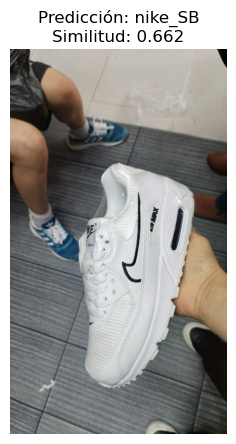


🔍 Resultados de similitud:
 - nike_SB: 0.662
 - AF1: 0.618
 - samba: 0.604
 - TN: 0.602
 - EQ: 0.591
 - green_SB: 0.585

📸 Nueva imagen detectada: 1760131735190.jpeg
✅ Archivo completamente guardado, iniciando análisis...


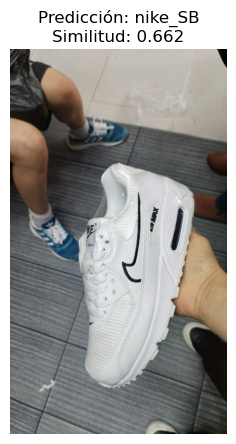


🔍 Resultados de similitud:
 - nike_SB: 0.662
 - AF1: 0.618
 - samba: 0.604
 - TN: 0.602
 - EQ: 0.591
 - green_SB: 0.585

📸 Nueva imagen detectada: 1760132396856.jpeg
✅ Archivo completamente guardado, iniciando análisis...


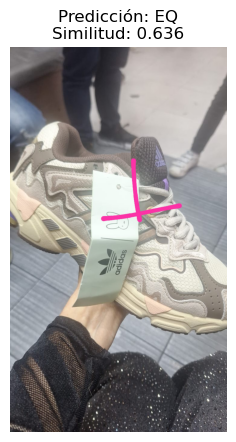


🔍 Resultados de similitud:
 - EQ: 0.636
 - samba: 0.613
 - green_SB: 0.612
 - nike_SB: 0.600
 - AF1: 0.594
 - TN: 0.577

📸 Nueva imagen detectada: 1760133442978.jpeg
✅ Archivo completamente guardado, iniciando análisis...


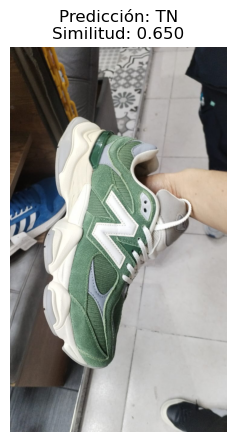


🔍 Resultados de similitud:
 - TN: 0.650
 - green_SB: 0.639
 - EQ: 0.630
 - samba: 0.623
 - nike_SB: 0.604
 - AF1: 0.601

📸 Nueva imagen detectada: 1760133517411.jpeg
✅ Archivo completamente guardado, iniciando análisis...


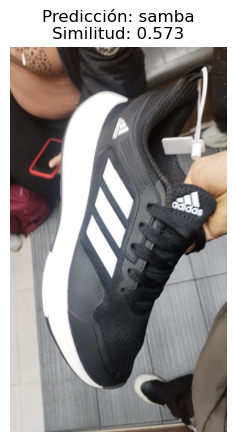


🔍 Resultados de similitud:
 - samba: 0.573
 - nike_SB: 0.560
 - TN: 0.557
 - AF1: 0.547
 - EQ: 0.545
 - green_SB: 0.540

📸 Nueva imagen detectada: 1760133892943.jpeg
✅ Archivo completamente guardado, iniciando análisis...


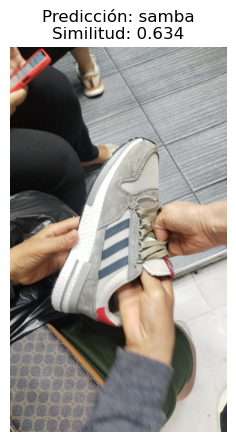


🔍 Resultados de similitud:
 - samba: 0.634
 - EQ: 0.620
 - TN: 0.619
 - AF1: 0.619
 - nike_SB: 0.613
 - green_SB: 0.602

📸 Nueva imagen detectada: 1760133903709.jpeg
✅ Archivo completamente guardado, iniciando análisis...


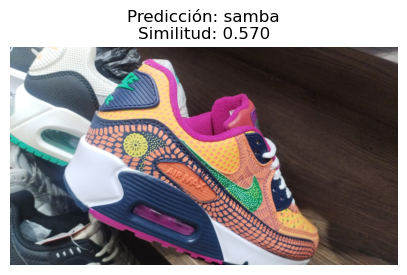


🔍 Resultados de similitud:
 - samba: 0.570
 - AF1: 0.564
 - green_SB: 0.562
 - EQ: 0.555
 - TN: 0.555
 - nike_SB: 0.544

📸 Nueva imagen detectada: 1760133920453.jpeg
✅ Archivo completamente guardado, iniciando análisis...


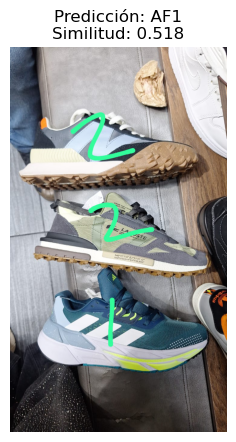


🔍 Resultados de similitud:
 - AF1: 0.518
 - samba: 0.518
 - nike_SB: 0.516
 - TN: 0.512
 - green_SB: 0.511
 - EQ: 0.511

📸 Nueva imagen detectada: 1760133959412.jpeg
✅ Archivo completamente guardado, iniciando análisis...


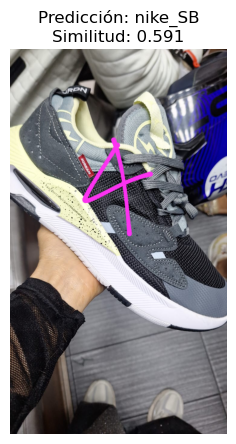


🔍 Resultados de similitud:
 - nike_SB: 0.591
 - samba: 0.582
 - AF1: 0.580
 - green_SB: 0.577
 - EQ: 0.571
 - TN: 0.559

📸 Nueva imagen detectada: 1760134015095.jpeg
✅ Archivo completamente guardado, iniciando análisis...


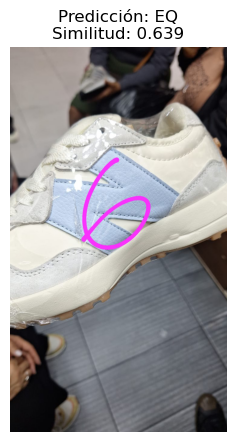


🔍 Resultados de similitud:
 - EQ: 0.639
 - nike_SB: 0.630
 - AF1: 0.625
 - green_SB: 0.619
 - TN: 0.609
 - samba: 0.605

📸 Nueva imagen detectada: 1760134230596.jpeg
✅ Archivo completamente guardado, iniciando análisis...


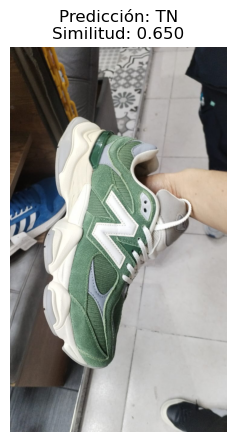


🔍 Resultados de similitud:
 - TN: 0.650
 - green_SB: 0.639
 - EQ: 0.630
 - samba: 0.623
 - nike_SB: 0.604
 - AF1: 0.601

📸 Nueva imagen detectada: 1760134443217.jpeg
✅ Archivo completamente guardado, iniciando análisis...


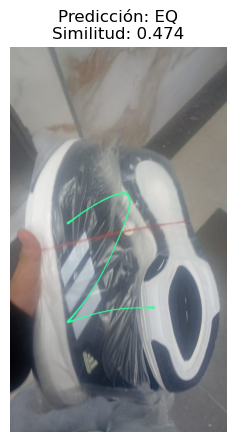


🔍 Resultados de similitud:
 - EQ: 0.474
 - nike_SB: 0.466
 - green_SB: 0.463
 - AF1: 0.463
 - samba: 0.462
 - TN: 0.449

📸 Nueva imagen detectada: 1760135034011.jpeg
✅ Archivo completamente guardado, iniciando análisis...


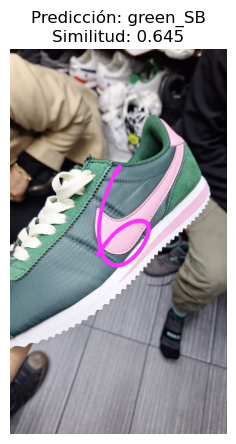


🔍 Resultados de similitud:
 - green_SB: 0.645
 - samba: 0.642
 - AF1: 0.634
 - nike_SB: 0.630
 - EQ: 0.629
 - TN: 0.625

📸 Nueva imagen detectada: 1760135341197.jpeg
✅ Archivo completamente guardado, iniciando análisis...


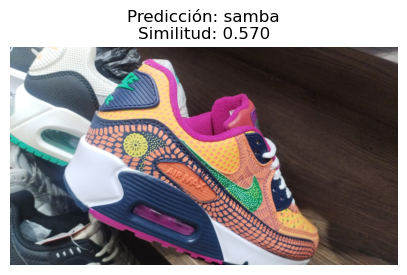


🔍 Resultados de similitud:
 - samba: 0.570
 - AF1: 0.564
 - green_SB: 0.562
 - EQ: 0.555
 - TN: 0.555
 - nike_SB: 0.544

📸 Nueva imagen detectada: 1760136263986.jpeg
✅ Archivo completamente guardado, iniciando análisis...


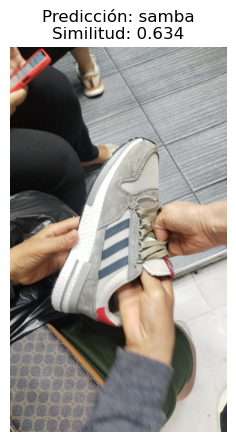


🔍 Resultados de similitud:
 - samba: 0.634
 - EQ: 0.620
 - TN: 0.619
 - AF1: 0.619
 - nike_SB: 0.613
 - green_SB: 0.602

📸 Nueva imagen detectada: 1760136415559.jpeg
✅ Archivo completamente guardado, iniciando análisis...


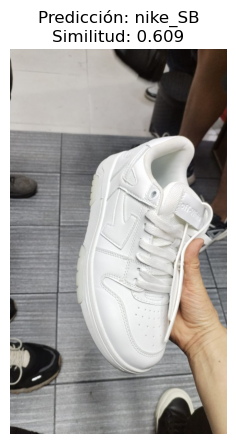


🔍 Resultados de similitud:
 - nike_SB: 0.609
 - AF1: 0.592
 - samba: 0.589
 - green_SB: 0.586
 - TN: 0.586
 - EQ: 0.564

📸 Nueva imagen detectada: 1760137062087.jpeg
✅ Archivo completamente guardado, iniciando análisis...


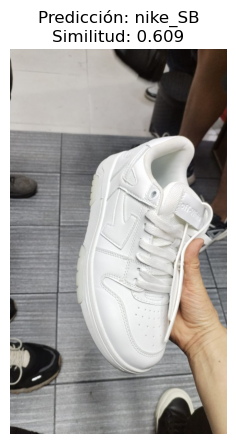


🔍 Resultados de similitud:
 - nike_SB: 0.609
 - AF1: 0.592
 - samba: 0.589
 - green_SB: 0.586
 - TN: 0.586
 - EQ: 0.564

📸 Nueva imagen detectada: 1760137139026.jpeg
✅ Archivo completamente guardado, iniciando análisis...


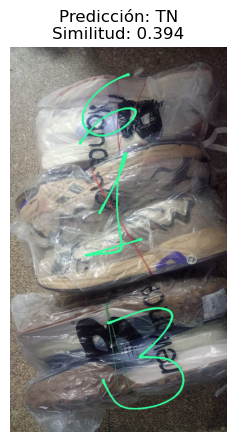


🔍 Resultados de similitud:
 - TN: 0.394
 - samba: 0.391
 - nike_SB: 0.381
 - green_SB: 0.373
 - AF1: 0.369
 - EQ: 0.357

📸 Nueva imagen detectada: 1760137670158.jpeg
✅ Archivo completamente guardado, iniciando análisis...


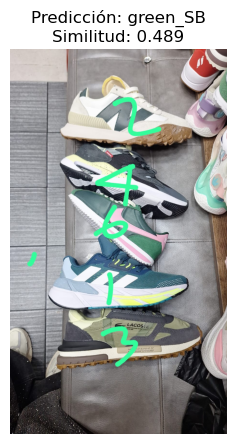


🔍 Resultados de similitud:
 - green_SB: 0.489
 - samba: 0.486
 - nike_SB: 0.485
 - EQ: 0.473
 - AF1: 0.466
 - TN: 0.459

📸 Nueva imagen detectada: 1760138322943.jpeg
✅ Archivo completamente guardado, iniciando análisis...


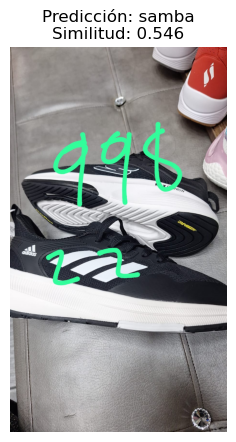


🔍 Resultados de similitud:
 - samba: 0.546
 - green_SB: 0.534
 - TN: 0.528
 - nike_SB: 0.524
 - AF1: 0.520
 - EQ: 0.516


In [ ]:
# =====================================================
# CLASIFICADOR AUTOMÁTICO DE TENIS CON WATCHDOG
# =====================================================

import os
import time
import numpy as np
import cv2
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# =====================================================
# 1. CONFIGURACIÓN
# =====================================================

CARPETA_ENTRADAS = "2025-10-10"
FEATURES_FILE = "tenis_features.npy"
COLORS_FILE = "tenis_colors.npy"

# Cargar modelo base
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# =====================================================
# 2. FUNCIONES DE PROCESAMIENTO
# =====================================================

def extraer_features(img_path):
    """Extrae las características visuales (forma/textura) con MobileNetV2."""
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat[0]

def promedio_color(img_path):
    """Calcula el color promedio RGB de la imagen."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.mean(axis=(0,1))

def clasificar_tenis(imagen_nueva, alpha=0.8):
    """Clasifica la imagen dada y muestra los resultados visualmente."""
    tenis_features = np.load(FEATURES_FILE, allow_pickle=True).item()
    tenis_colors = np.load(COLORS_FILE, allow_pickle=True).item()

    feat_new = extraer_features(imagen_nueva)
    color_new = promedio_color(imagen_nueva)

    resultados = []
    for nombre, feat_avg in tenis_features.items():
        color_avg = tenis_colors[nombre]
        sim_forma = cosine_similarity([feat_new], [feat_avg])[0][0]
        dist_color = np.linalg.norm(color_avg - color_new)
        sim_color = 1 / (1 + dist_color)
        sim_total = alpha * sim_forma + (1 - alpha) * sim_color
        resultados.append((nombre, sim_total))

    resultados.sort(key=lambda x: x[1], reverse=True)
    mejor = resultados[0]

    # Mostrar resultado visual
    plt.figure(figsize=(5, 5))
    plt.imshow(image.load_img(imagen_nueva))
    plt.title(f"Predicción: {mejor[0]}\nSimilitud: {mejor[1]:.3f}")
    plt.axis('off')
    plt.show()

    print("\n🔍 Resultados de similitud:")
    for nombre, sim in resultados:
        print(f" - {nombre}: {sim:.3f}")

# =====================================================
# 3. WATCHDOG: MONITOREO AUTOMÁTICO DE NUEVAS IMÁGENES
# =====================================================

class WatchHandler(FileSystemEventHandler):
    def esperar_archivo_completo(self, filepath, tiempo_espera=0.5, reintentos=8):
        """
        Espera hasta que el archivo deje de cambiar de tamaño.
        Ideal para imágenes pequeñas (~150 KB).
        """
        for _ in range(reintentos):
            try:
                size1 = os.path.getsize(filepath)
                time.sleep(tiempo_espera)
                size2 = os.path.getsize(filepath)
                if size1 == size2:
                    return True
            except FileNotFoundError:
                pass
        return False

    def on_created(self, event):
        """Se ejecuta cuando llega una nueva imagen a la carpeta."""
        if not event.is_directory and event.src_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = event.src_path
            print(f"\n📸 Nueva imagen detectada: {os.path.basename(filepath)}")

            if self.esperar_archivo_completo(filepath):
                print("✅ Archivo completamente guardado, iniciando análisis...")
                clasificar_tenis(filepath, alpha=0.8)
            else:
                print(f"⚠️ Archivo {os.path.basename(filepath)} no se estabilizó a tiempo, omitido.")

# =====================================================
# 4. EJECUTAR MONITOREO
# =====================================================

def iniciar_watchdog():
    """Inicia el monitoreo de la carpeta 'carpeta_entradas'."""
    os.makedirs(CARPETA_ENTRADAS, exist_ok=True)
    print(f"👀 Monitoreando carpeta: {CARPETA_ENTRADAS}")
    print("Arrastra o guarda aquí las imágenes a clasificar...\n")

    observer = Observer()
    observer.schedule(WatchHandler(), CARPETA_ENTRADAS, recursive=False)
    observer.start()

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
        print("🛑 Monitoreo detenido.")
    observer.join()

# =====================================================
# 5. INICIO
# =====================================================

iniciar_watchdog()


## codigo completo para verificar inventario

In [ ]:
# =====================================================
# CLASIFICADOR AUTOMÁTICO DE TENIS + INVENTARIO SIMPLE
# =====================================================

import os
import time
import numpy as np
import pandas as pd
import cv2
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# =====================================================
# 1. CONFIGURACIÓN
# =====================================================

CARPETA_ENTRADAS = "carpeta_entradas"
FEATURES_FILE = "tenis_features.npy"
COLORS_FILE = "tenis_colors.npy"
INVENTARIO_FILE = "inventario.csv"  # archivo CSV con modelo,talla,stock

model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')

# =====================================================
# 2. FUNCIONES
# =====================================================

def extraer_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    feat = model.predict(x, verbose=0)
    return feat[0]

def promedio_color(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img.mean(axis=(0,1))

def buscar_inventario(nombre_modelo):
    """Busca tallas disponibles en el inventario CSV."""
    if not os.path.exists(INVENTARIO_FILE):
        print("⚠️ No se encontró el archivo de inventario.")
        return None

    inv = pd.read_csv(INVENTARIO_FILE)
    disponibles = inv[(inv["modelo"] == nombre_modelo) & (inv["stock"] > 0)]
    if disponibles.empty:
        return None

    tallas = [f"{row.talla} ({int(row.stock)} uds)" for _, row in disponibles.iterrows()]
    return tallas

def clasificar_tenis(imagen_nueva, alpha=0.8):
    tenis_features = np.load(FEATURES_FILE, allow_pickle=True).item()
    tenis_colors = np.load(COLORS_FILE, allow_pickle=True).item()

    feat_new = extraer_features(imagen_nueva)
    color_new = promedio_color(imagen_nueva)

    similitudes = []
    for nombre, feat_avg in tenis_features.items():
        color_avg = tenis_colors[nombre]
        sim_forma = cosine_similarity([feat_new], [feat_avg])[0][0]
        dist_color = np.linalg.norm(color_avg - color_new)
        sim_color = 1 / (1 + dist_color)
        sim_total = alpha * sim_forma + (1 - alpha) * sim_color
        similitudes.append((nombre, sim_total))

    similitudes.sort(key=lambda x: x[1], reverse=True)
    mejor = similitudes[0]  # solo el más parecido

    # Buscar inventario
    tallas_disp = buscar_inventario(mejor[0])

    # Mostrar imagen con información
    plt.figure(figsize=(5, 5))
    plt.imshow(image.load_img(imagen_nueva))
    titulo = f"Predicción: {mejor[0]}\nSimilitud: {mejor[1]:.3f}"
    if tallas_disp:
        titulo += f"\nTallas disponibles: {', '.join(tallas_disp)}"
    else:
        titulo += "\n⚠️ Sin stock disponible"
    plt.title(titulo)
    plt.axis('off')
    plt.show()

    print(f"\n✅ Predicción: {mejor[0]} (Similitud {mejor[1]:.3f})")
    if tallas_disp:
        print(f"📦 Tallas disponibles: {', '.join(tallas_disp)}")
    else:
        print("❌ Sin stock disponible")

# =====================================================
# 3. WATCHDOG (MONITOREO AUTOMÁTICO)
# =====================================================

class WatchHandler(FileSystemEventHandler):
    def esperar_archivo_completo(self, filepath, tiempo_espera=0.5, reintentos=8):
        for _ in range(reintentos):
            try:
                size1 = os.path.getsize(filepath)
                time.sleep(tiempo_espera)
                size2 = os.path.getsize(filepath)
                if size1 == size2:
                    return True
            except FileNotFoundError:
                pass
        return False

    def on_created(self, event):
        if not event.is_directory and event.src_path.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepath = event.src_path
            print(f"\n📸 Nueva imagen detectada: {os.path.basename(filepath)}")

            if self.esperar_archivo_completo(filepath):
                print("✅ Archivo completamente guardado. Analizando...")
                clasificar_tenis(filepath, alpha=0.8)
            else:
                print(f"⚠️ Archivo {os.path.basename(filepath)} no se estabilizó a tiempo, omitido.")

def iniciar_watchdog():
    os.makedirs(CARPETA_ENTRADAS, exist_ok=True)
    print(f"👀 Monitoreando carpeta: {CARPETA_ENTRADAS}")
    print("Guarda aquí las imágenes que quieras clasificar...\n")

    observer = Observer()
    observer.schedule(WatchHandler(), CARPETA_ENTRADAS, recursive=False)
    observer.start()

    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        observer.stop()
        print("🛑 Monitoreo detenido.")
    observer.join()

# =====================================================
# 4. INICIO
# =====================================================

iniciar_watchdog()
